# QuickDraw Data

If machine learning is rocket science then data is your fuel! So before
doing anything we will have a close look at the data available and spend
some time bringing it into the "right" form (i.e.
[tf.train.Example](https://www.tensorflow.org/api_docs/python/tf/train/Example)).

That's why we start by spending quite a lot of time on this notebook, downloading
the data, understanding it, and transforming it into the right format for
Tensorflow.

The data used in this workshop is taken from Google's quickdraw (click on
the images to see loads of examples):

https://quickdraw.withgoogle.com/data

We will download the data below.

## Init

First, we'll choose where our data should be stored.

If you choose a path under **"/content/gdrive/My Drive"** then data will be stored in your Google drive and persisted across VM starts (preferable).

In [0]:
data_path = '/content/gdrive/My Drive/amld_data'
# Alternatively, you can also store the data in a local directory. This method
# will also work when running the notebook in Jupyter instead of Colab.
# data_path = './amld_data

In [2]:
if data_path.startswith('/content/gdrive/'):
  from google.colab import drive
  assert data_path.startswith('/content/gdrive/My Drive/'), 'Google Drive paths must start with "/content/gdrive/My Drive/"!'
  drive.mount('/content/gdrive')

if data_path.startswith('gs://'):
  from google.colab import auth
  auth.authenticate_user()

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# In Jupyter, you would need to install TF 2 via !pip.
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [4]:
# Always make sure you are using running the expected version.
# There are considerable differences between versions.
# This Colab was tested with 2.1.0.
import tensorflow as tf
tf.__version__

'2.1.0'

In [0]:
import base64, collections, io, itertools, functools, json, os, random, re, textwrap, time, urllib, xml

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw
from IPython import display

## Get the data

In this section we download a set of raw data files from the web.

In [6]:
# Retrieve list of categories.

def list_bucket(bucket, regexp='.*'):
    """Returns a filtered list of Keys in specified GCS bucket."""
    keys = []
    fh = urllib.request.urlopen('https://storage.googleapis.com/%s' % bucket)
    content = xml.dom.minidom.parseString(fh.read())
    for e in content.getElementsByTagName('Contents'):
        key = e.getElementsByTagName('Key')[0].firstChild.data
        if re.match(regexp, key):
            keys.append(key)
    return keys

all_ndjsons = list_bucket('quickdraw_dataset', '.*ndjson$')
print('available: (%d)' % len(all_ndjsons))
print('\n'.join(textwrap.wrap(
    '|'.join([key.split('/')[-1].split('.')[0] for key in all_ndjsons]),
    width=100)))

available: (309)
The Eiffel Tower|The Great Wall of China|The Mona Lisa|aircraft carrier|airplane|alarm
clock|ambulance|angel|animal
migration|ant|anvil|apple|arm|asparagus|axe|backpack|banana|bandage|barn|baseball bat|baseball|baske
t|basketball|bat|bathtub|beach|bear|beard|bed|bee|belt|bench|bicycle|binoculars|bird|birthday cake|b
lackberry|blueberry|book|boomerang|bottlecap|bowtie|bracelet|brain|bread|bridge|broccoli|broom|bucke
t|bulldozer|bus|bush|butterfly|cactus|cake|calculator|calendar|camel|camera|camouflage|campfire|cand
le|cannon|canoe|car|carrot|castle|cat|ceiling fan|cell
phone|cello|chair|chandelier|church|circle|clarinet|clock|cloud|coffee
cup|compass|computer|cookie|cooler|couch|cow|crab|crayon|crocodile|crown|cruise
ship|cup|diamond|dishwasher|diving board|dog|dolphin|donut|door|dragon|dresser|drill|drums|duck|dumb
bell|ear|elbow|elephant|envelope|eraser|eye|eyeglasses|face|fan|feather|fence|finger|fire
hydrant|fireplace|firetruck|fish|flamingo|flashlight|flip flops|fl

In [0]:
# Mini group of two animals.
pets = ['cat', 'dog']

# Somewhat larger group of zoo animals.
zoo = ['camel', 'crocodile', 'dolphin', 'elephant', 'flamingo', 'giraffe',
       'kangaroo', 'lion', 'monkey', 'penguin', 'rhinoceros']

# Even larger group of all animals.
animals = ['ant', 'bat', 'bear', 'bee', 'bird', 'butterfly', 'camel', 'cat',
           'cow', 'crab', 'crocodile', 'dog', 'dolphin', 'dragon', 'duck',
           'elephant', 'fish', 'flamingo', 'frog', 'giraffe', 'hedgehog',
           'horse', 'kangaroo', 'lion', 'lobster', 'monkey', 'mosquito',
           'mouse', 'octopus', 'owl', 'panda', 'parrot', 'penguin', 'pig',
           'rabbit', 'raccoon', 'rhinoceros', 'scorpion', 'sea turtle', 'shark',
           'sheep', 'snail', 'snake', 'spider', 'squirrel', 'swan']

# You could do something like:
# my_objects = ['shoe', 'shorts', 't-shirt']

Create your own group -- the more categories you include the more challenging the classification task will be...

In [0]:
# YOUR ACTION REQUIRED:
# Choose one of above groups for remainder of workshop.
# Note: This will result in ~100MB of download per class.
# `dataset_name` will be used to construct directories containing the data.
labels, dataset_name = zoo, 'zoo'

# Or use another dataset defined above:
# labels, dataset_name = pets, 'pets'
# labels, dataset_name = animals, 'animals'

In [9]:
# Download above chosen group.

def valid_ndjson(filename):
  """Checks presence + completeness of .ndjson file."""
  try:
    json.loads(tf.io.gfile.GFile(filename).readlines()[-1])
    return True
  except (ValueError, IOError):
    return False

def retrieve(bucket, key, filename):
  """Returns a file specified by its Key from a GCS bucket."""
  url = 'https://storage.googleapis.com/%s/%s' % (
    bucket, urllib.parse.quote(key))
  print('\n' + url)
  if not tf.io.gfile.exists(filename):
    with tf.io.gfile.GFile(filename, 'w') as f:
      f.write(urllib.request.urlopen(url).read())
  while not valid_ndjson(filename):
    print('*** Corrupted download (%.2f MB), retrying...' % (
        os.path.getsize(filename) / 2.**20))
    with tf.io.gfile.GFile(filename, 'w') as f:
      f.write(urllib.request.urlopen(url).read())

tf.io.gfile.makedirs(data_path)

print('\n%d labels:' % len(labels))

for name in labels:
  print(name, end=' ')
  dst = '%s/%s.ndjson' % (data_path, name)
  retrieve('quickdraw_dataset', 'full/simplified/%s.ndjson' % name, dst)
  print('%.2f MB' % (tf.io.gfile.stat(dst).length / 2.**20))

print('\nDONE :)')


11 labels:
camel 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/camel.ndjson
54.31 MB
crocodile 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/crocodile.ndjson
57.19 MB
dolphin 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/dolphin.ndjson
46.29 MB
elephant 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/elephant.ndjson
70.86 MB
flamingo 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/flamingo.ndjson
54.56 MB
giraffe 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/giraffe.ndjson
58.27 MB
kangaroo 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/kangaroo.ndjson
96.06 MB
lion 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/lion.ndjson
90.47 MB
monkey 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/monkey.ndjson
91.05 MB
penguin 
https://storage.googleapis.com/quickdraw_dataset/full/simplified/penguin.ndjson
137.90 MB
rhinocero

## Inspect the data

Let's find out what the format of the downloaded files is.

First, we are going to enumerate them.

In [10]:
print('\n'.join([
                 '%6.1fM : %s' % (tf.io.gfile.stat(path).length/1024**2, path)
                 for path in tf.io.gfile.glob('{}/*.ndjson'.format(data_path))
                 ]))

  70.9M : /content/gdrive/My Drive/amld_data/elephant.ndjson
  58.3M : /content/gdrive/My Drive/amld_data/giraffe.ndjson
  96.1M : /content/gdrive/My Drive/amld_data/kangaroo.ndjson
  90.5M : /content/gdrive/My Drive/amld_data/lion.ndjson
  91.1M : /content/gdrive/My Drive/amld_data/monkey.ndjson
  97.0M : /content/gdrive/My Drive/amld_data/panda.ndjson
 137.9M : /content/gdrive/My Drive/amld_data/penguin.ndjson
  92.2M : /content/gdrive/My Drive/amld_data/rhinoceros.ndjson
  86.1M : /content/gdrive/My Drive/amld_data/tiger.ndjson
  92.1M : /content/gdrive/My Drive/amld_data/zebra.ndjson
  54.3M : /content/gdrive/My Drive/amld_data/camel.ndjson
  57.2M : /content/gdrive/My Drive/amld_data/crocodile.ndjson
  46.3M : /content/gdrive/My Drive/amld_data/dolphin.ndjson
  54.6M : /content/gdrive/My Drive/amld_data/flamingo.ndjson


Let's further explore what the `NDJSON` file format is.

In [11]:
path = sorted(tf.io.gfile.glob(os.path.join(data_path, '*.ndjson')))[0]
print(path)
print(tf.io.gfile.GFile(path).read()[:1000] + '...')

/content/gdrive/My Drive/amld_data/camel.ndjson
{"word":"camel","countrycode":"AU","timestamp":"2017-03-09 09:13:23.70821 UTC","recognized":true,"key_id":"4652244525907968","drawing":[[[47,27,15,3,0,2,12,33,46,51,53,49,40],[0,4,11,25,38,51,58,57,48,40,27,17,8]],[[49,60,66,74,90,105,116,125,132,141,151,160,172,183,190,199,221,232,229,218,198,182,142,109,95,52,37,26],[44,60,63,59,36,33,44,69,73,65,38,33,36,54,77,83,88,106,121,136,149,155,154,143,136,101,79,49]],[[229,245,253,255,249],[95,105,114,131,169]],[[63,45,44,48],[99,155,171,172]],[[42,62,76],[161,162,120]],[[97,89,90,95,106,112,113],[130,152,165,170,171,164,139]],[[151,149,151,155,163],[153,159,170,176,179]]]}
{"word":"camel","countrycode":"PH","timestamp":"2017-01-26 03:02:58.05583 UTC","recognized":true,"key_id":"4641031645560832","drawing":[[[62,63,72,82,98,109,123,130,136],[77,59,39,24,16,18,31,59,68]],[[63,15,2,0,3,26,38,66,100,152,174,177,172,161,137],[79,86,97,107,114,131,134,139,136,115,95,81,71,67,65]],[[41,40,28],[137,1

As we can see, it's a format that contains one JSON dictionary per line.

Let's parse one single line.

In [12]:
data_json = json.loads(tf.io.gfile.GFile(path).readline())
data_json.keys()

dict_keys(['word', 'countrycode', 'timestamp', 'recognized', 'key_id', 'drawing'])

In [13]:
# So we have some meta information.
for k, v in data_json.items():
  if k != 'drawing':
    print('%20s   ->   %s' % (k, v))

                word   ->   camel
         countrycode   ->   AU
           timestamp   ->   2017-03-09 09:13:23.70821 UTC
          recognized   ->   True
              key_id   ->   4652244525907968


In [14]:
# Extract the actual drawing.
drawing = data_json['drawing']

# The drawing consists of a series of strokes:
print('Shapes:', [np.array(stroke).shape for stroke in drawing])
print('Example stroke:', drawing[0])

Shapes: [(2, 13), (2, 28), (2, 5), (2, 4), (2, 3), (2, 7), (2, 5)]
Example stroke: [[47, 27, 15, 3, 0, 2, 12, 33, 46, 51, 53, 49, 40], [0, 4, 11, 25, 38, 51, 58, 57, 48, 40, 27, 17, 8]]


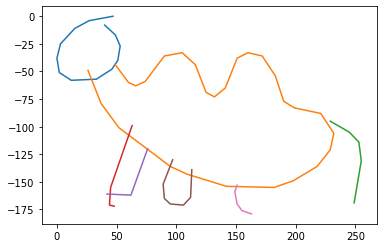

In [15]:
# Draw the image -- the strokes all have have shape (2, n)
# so the first index seems to be x/y coordinate:
for stroke in drawing:
  # Each array has X coordinates at [0, :] and Y coordinates at [1, :].
  plt.plot(np.array(stroke[0]), -np.array(stroke[1]))
# Would YOU recognize this drawing successfully?

In [16]:
# Some more code to load many sketches at once.
# Let's ignore the difficult `unrecognized` sketches for now
# (i.e. unrecognized by the official quickdraw classifier).

def convert(line):
  """Converts single JSON line and converts 'drawing' to list of np.array."""
  d = json.loads(line)
  d['drawing'] = [np.array(stroke) for stroke in d['drawing']]
  return d

def loaditer(name, unrecognized=False):
  """Returns iterable of drawings in specified file.

  Args:
    name: Name of the downloaded object (e.g. "elephant").
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  for line in tf.io.gfile.GFile('%s/%s.ndjson' % (data_path, name)):
    d = convert(line)  
    if d['recognized'] or unrecognized:
      yield d

def loadn(name, n, unrecognized=False):
  """Returns list of drawings.
  
  Args:
    name: Name of the downloaded object (e.g. "elephant").
    n: Number of drawings to load.
    unrecognized: Whether to include drawings that were not recognized
        by Google AI (i.e. the hard ones).
  """
  it = loaditer(name, unrecognized=unrecognized)
  return list(itertools.islice(it, 0, n))

n = 100
print('Loading {} instances of "{}"...'.format(n, labels[0]), end='')
sample = loadn(labels[0], 100)
print('done.')

Loading 100 instances of "camel"...done.


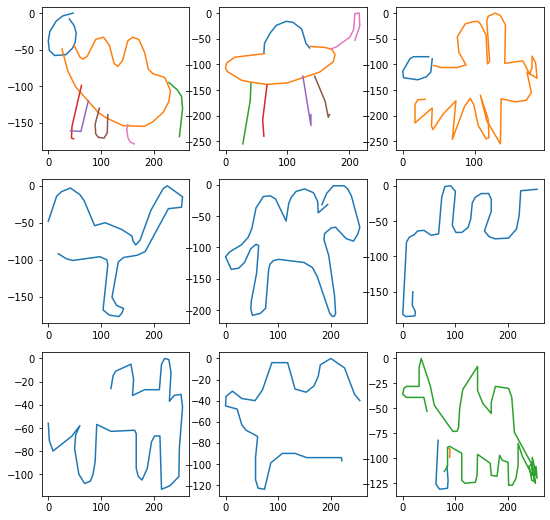

In [17]:
# Some more drawings.
rows, cols = 3, 3
plt.figure(figsize=(3*cols, 3*rows))
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    plt.subplot(rows, cols, i + 1)
    for stroke in sample[i]['drawing']:
      plt.plot(np.array(stroke[0]), -np.array(stroke[1]))

## Rasterize

Idea: After converting the raw drawing data into rasterized images, we can
use [MNIST](https://www.tensorflow.org/tutorials/quickstart/beginner)-like
image processing to classify the drawings.

In [0]:
def dict_to_img(drawing, img_sz=64, lw=3, maximize=True):
  """Converts QuickDraw data to quadratic rasterized image.
  
  Args:
    drawing: Dictionary instance of QuickDraw dataset.
    img_sz: Size output image (in pixels).
    lw: Line width (in pixels).
    maximize: Whether to maximize drawing within image pixels.
    
  Returns:
    A PIL.Image with the rasterized drawing.
  """
  img = Image.new('L', (img_sz, img_sz))
  draw = ImageDraw.Draw(img)
  lines = np.array([
      stroke[0:2, i:i+2]
      for stroke in drawing['drawing']
      for i in range(stroke.shape[1] - 1)
  ], dtype=np.float32)
  if maximize:
    for i in range(2):
      min_, max_ = lines[:,i,:].min() * 0.95, lines[:,i,:].max() * 1.05
      lines[:,i,:] = (lines[:,i,:] - min_) / max(max_ - min_, 1)
  else:
    lines /= 1024
  for line in lines:
    draw.line(tuple(line.T.reshape((-1,)) * img_sz), fill='white', width=lw)
  return img


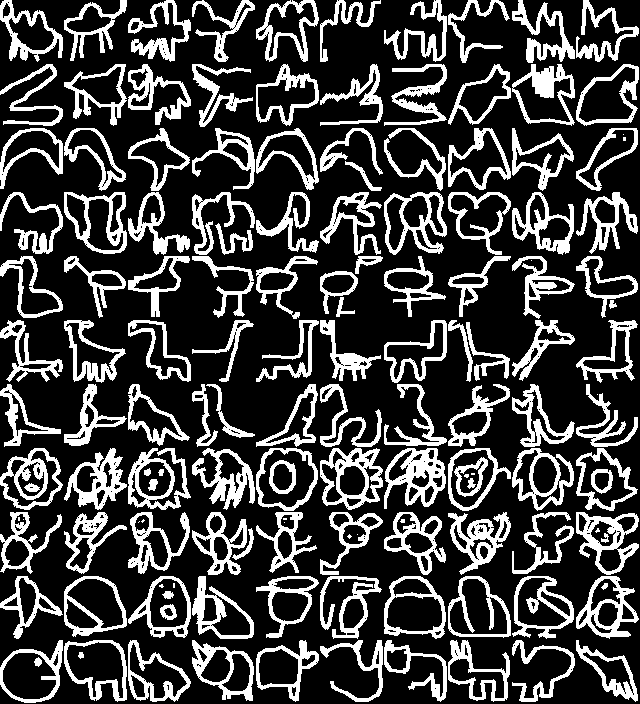

10 samples of : camel crocodile dolphin elephant flamingo giraffe kangaroo lion monkey penguin rhinoceros


In [19]:
# Show some examples.

def showimg(img):
  """Shows an image with an inline HTML <img> tag.
  
  Args:
    img: Can be a PIL.Image or a numpy.ndarray.
  """
  if isinstance(img, np.ndarray):
    img = Image.fromarray(img, 'L')
  b = io.BytesIO()
  img.convert('RGB').save(b, format='png')
  enc = base64.b64encode(b.getvalue()).decode('utf-8')
  display.display(display.HTML(
      '<img src="data:image/png;base64,%s">' % enc))

# Fetch some images + shuffle order.
rows, cols = len(labels), 10
n_per_class = rows * cols // len(labels) + 1
drawings_list = [drawing for name in labels
                 for drawing in loadn(name, cols)]

# Create mosaic of rendered images.
lw = 4
img_sz = 64
tableau = np.zeros((img_sz * rows, img_sz * cols), dtype=np.uint8)
for y in range(rows):
  for x in range(cols):
    i = y * cols + x
    img = dict_to_img(drawings_list[i], img_sz=img_sz, lw=lw, maximize=True)
    tableau[y*img_sz:(y+1)*img_sz,
            x*img_sz:(x+1)*img_sz] = np.asarray(img)

showimg(tableau)
print('{} samples of : {}'.format(cols, ' '.join(labels)))

## Protobufs and tf.train.Example

Tensorflow's "native" format for data storage is the `tf.train.Example`
[protocol buffer](https://en.wikipedia.org/wiki/Protocol_Buffers).

In this section we briefly explore the API needed to access the data
inside the `tf.train.Example` protocol buffer. It's **not necessary** to read
through the
[Protocol Buffer Basics: Python - documentation](https://developers.google.com/protocol-buffers/docs/pythontutorial).

In [20]:
# Create a new (empty) instance.
example = tf.train.Example()

# An empty example will not print anything.
print(example)

# An example contains a map from feature name to "Feature".
# Every "Feature" contains a list of elements of the same
# type, which is one of:
# - bytes_list (similar to Python's "str")
# - float_list (float number)
# - int64_list (integer number)

# These values can be accessed as follows (no need to understand
# details):
# Add float value "3.1416" to feature "magic_numbers"
example.features.feature['magic_numbers'].float_list.value.append(3.1416)
# Add some more values to the float list "magic_numbers".
example.features.feature['magic_numbers'].float_list.value.extend([2.7183, 1.4142, 1.6180])

### YOUR ACTION REQUIRED:
# Create a second feature named "adversaries" and add the elements
# b'Alice' and b'Bob'.
example.features.feature['adversaries'].bytes_list.value.extend([b'Alice', b'Bob']) #example.features.feature['adversaries'].

# This will now print a serialized representation of our protocol buffer
# with features "magic_numbers" and "adversaries" set...
print(example)

# .. et voila : that's all you need to know about protocol buffers for this
# workshop.


features {
  feature {
    key: "adversaries"
    value {
      bytes_list {
        value: "Alice"
        value: "Bob"
      }
    }
  }
  feature {
    key: "magic_numbers"
    value {
      float_list {
        value: 3.1415998935699463
        value: 2.7183001041412354
        value: 1.414199948310852
        value: 1.6180000305175781
      }
    }
  }
}



## Create datasets

Now let's create a "dataset" of `tf.train.Example`
[protocol buffers](https://developers.google.com/protocol-buffers/) ("protos").

A single example will contain all the information we want to use for training for a drawing (i.e. rasterized
image, label, and maybe other information).

In [21]:
# Let's first check how many [recognized=True] examples we have in each class.
for name in labels:
  num_all_samples = len(list(tf.io.gfile.GFile('%s/%s.ndjson' % (data_path, name))))
  num_recognized_samples = len(list(loaditer(name)))
  print(name, num_all_samples, 'recognized', num_recognized_samples)

camel 121399 recognized 115454
crocodile 127932 recognized 106410
dolphin 121613 recognized 110335
elephant 126969 recognized 104986
flamingo 124569 recognized 116251
giraffe 127182 recognized 122396
kangaroo 174470 recognized 152511
lion 120949 recognized 98976
monkey 127633 recognized 105650
penguin 253791 recognized 231826
rhinoceros 188484 recognized 166539


**Sharding**

A dataset consists of non-overlapping sets of examples that will be used for
training and evaluation of the classifier (the "test" set will be used for the
final evaluation). As these files can quickly become very large, we split them into smaller files referred to as *shards*.
For example, we could split a single dataset into a number of *shards*, like
* train-00000-of-00005,
* train-00001-of-00005,
*  ...,
* train-00004-of-00005 (if we're using 5 shards).

This way we have smaller individual files, and we can also easily access for example only 20% of all data, or have 5 threads which read through all the data
simultaneously.

Generally, with large datasets, a recommendation is to split data into individual *shards* with a size of ~100 MB each. This workshop might use smaller sharding sizes for simplicity reasons. 

In [0]:
#@title `make_sharded_files()` code
#@markdown Helper code to create sharded recordio files.
#@markdown Simply **click "execute"** and continue to the next cell.
#@markdown No need to read through this code to understand the remainder of the Colab.
#@markdown 
#@markdown If you want to have a look anyways, you can double-click this cell or click on the three dots
#@markdown and then select "Form" and then "Show Code" (shortcut `<Ctrl-M> <F>`).

# Helper code to create sharded recordio files.
# (No need to read through this.)

# The code in this cell simply takes a list of iterators and then
# randomly distributes the values returned by these iterators into sharded
# datasets (e.g. a train/eval/test split).

def rand_key(counts):
  """Returns a random key from "counts", using values as distribution."""
  r = random.randint(0, sum(counts.values()))
  for key, count in counts.items():
    if r > count or count == 0:
      r -= count
    else:
      counts[key] -= 1
      return key

def get_split(i, splits):
  """Returns key from "splits" for iteration "i"."""
  i %= sum(splits.values())
  for split in sorted(splits):
    if i < splits[split]:
      return split
    i -= splits[split]

def make_counts(labels, total):
  """Generates counts for "labels" totaling "total"."""
  counts = {}
  for i, name in enumerate(labels):
    counts[name] = total // (len(labels) - i)
    total -= counts[name]
  return counts

def example_to_dict(example):
  """Converts a tf.train.Example to a dictionary."""
  example_dict = {}
  for name, value in example.features.feature.items():
    if value.HasField('bytes_list'):
      value = value.bytes_list.value
    elif value.HasField('int64_list'):
      value = value.int64_list.value
    elif value.HasField('float_list'):
      value = value.float_list.value
    else:
      raise 'Unknown *_list type!'
    if len(value) == 1:
      example_dict[name] = value[0]
    else:
      example_dict[name] = np.array(value)
  return example_dict

def make_sharded_files(make_example, path, labels, iters, counts, splits,
                       shards=10, overwrite=False, report_dt=10, make_df=False):
  """Create sharded dataset from "iters".

  Args:
    make_example: Converts object returned by elements of "iters"
        to tf.train.Example() proto.
    path: Directory that will contain recordio files.
    labels: Names of labels, will be written to "labels.txt".
    iters: List of iterables returning drawing objects.
    counts: Dictionary mapping class to number of examples.
    splits: Dictionary mapping filename to multiple examples. For example,
        splits=dict(a=2, b=1) will result in two examples being written to "a"
        for every example being written to "b".
    shards: Number of files to be created per split.
    overwrite: Whether a pre-existing directory should be overwritten.
    report_dt: Number of seconds between status updates (0=no updates).
    make_df: Also write data as pandas.DataFrame - do NOT use this with very
        large datasets that don't fit in memory!

  Returns:
    Total number of examples written to disk per split.
  """
  assert len(iters) == len(labels)
  # Prepare output.
  if not tf.io.gfile.exists(path):
    tf.io.gfile.makedirs(path)
  paths = {
      split: ['%s/%s-%05d-of-%05d' % (path, split, i, shards)
              for i in range(shards)]
      for split in splits
  }
  assert overwrite or not tf.io.gfile.exists(paths.values()[0][0])
  writers = {
      split: [tf.io.TFRecordWriter(ps[i]) for i in range(shards)]
      for split, ps in paths.items()
  }
  t0 = time.time()
  examples_per_split = collections.defaultdict(int)
  i, n = 0, sum(counts.values())
  counts = dict(**counts)
  rows = []
  # Create examples.
  while sum(counts.values()):
    name = rand_key(counts)
    split = get_split(i, splits)
    writer = writers[split][examples_per_split[split] % shards]
    label = labels.index(name)
    example = make_example(label, next(iters[label]))
    writer.write(example.SerializeToString())
    if make_df:
      example.features.feature['split'].bytes_list.value.append(split.encode('utf8'))
      rows.append(example_to_dict(example))
    examples_per_split[split] += 1
    i += 1
    if report_dt > 0 and time.time() - t0 > report_dt:
      print('processed %d/%d (%.2f%%)' % (i, n, 100. * i / n))
      t0 = time.time()
  # Store results.
  for split in splits:
    for writer in writers[split]:
      writer.close()
  with tf.io.gfile.GFile('%s/labels.txt' % path, 'w') as f:
    f.write('\n'.join(labels))
  with tf.io.gfile.GFile('%s/counts.json' % path, 'w') as f:
    json.dump(examples_per_split, f)
  if make_df:
    df_path = '%s/dataframe.pkl' % path
    print('Writing %s...' % df_path)
    pd.DataFrame(rows).to_pickle(df_path)
  return dict(**examples_per_split)

### Create IMG dataset

In [0]:
# Uses `dict_to_img()` from previous cell to create raster image.

def make_example_img(label, drawing):
  """Converts QuickDraw dictionary to example with rasterized data.
  
  Args:
    label: Numerical representation of the label (e.g. '0' for labels[0]).
    drawing: Dictionary with QuickDraw data.

  Returns:
    A tf.train.Example protocol buffer (with 'label', 'img_64', and additional
    metadata features).
  """
  example = tf.train.Example()
  example.features.feature['label'].int64_list.value.append(label)
  img_64 = np.asarray(dict_to_img(
      drawing, img_sz=64, lw=4, maximize=True)).reshape(-1)
  example.features.feature['img_64'].int64_list.value.extend(img_64)
  example.features.feature['countrycode'].bytes_list.value.append(
      drawing['countrycode'].encode())
  example.features.feature['recognized'].int64_list.value.append(
      drawing['recognized'])
  example.features.feature['word'].bytes_list.value.append(
      drawing['word'].encode())
  ts = drawing['timestamp']
  ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
  example.features.feature['timestamp'].int64_list.value.append(int(ts))
  example.features.feature['key_id'].int64_list.value.append(
      int(drawing['key_id']))
  return example

We will now create a dataset with 80k samples consisting of:

*   50k samples used for training
*   20k samples used for evaluation
*   10k samples used for testing

The generation below will take about **~5 minutes**.

> **Note:** Larger datasets take longer to generate and to train on, but also lead to better classification results.



In [24]:
# Create the (rasterized) dataset.

path = '%s/%s_img' % (data_path, dataset_name)
t0 = time.time()
examples_per_split = make_sharded_files(
    make_example=make_example_img,
    path=path,
    labels=labels,
    iters=[loaditer(name) for name in labels],
    # Creating 50k train, 20k eval and 10k test examples.
    counts=make_counts(labels, 80000),
    splits=dict(train=5, eval=2, test=1),
    overwrite=True,
    # Note: Set this to False when generating large datasets.
    make_df=True,
)

# If you don't see the final output below, it's probably because your VM
# has run out of memory and crashed!
# This can happen when make_df=True.
print('stored data to "%s"' % path)
print('generated %s examples in %d seconds' % (
    examples_per_split, time.time() - t0))

processed 3510/80000 (4.39%)
processed 7160/80000 (8.95%)
processed 10745/80000 (13.43%)
processed 14389/80000 (17.99%)
processed 18039/80000 (22.55%)
processed 21697/80000 (27.12%)
processed 23808/80000 (29.76%)
processed 27535/80000 (34.42%)
processed 31032/80000 (38.79%)
processed 34679/80000 (43.35%)
processed 38302/80000 (47.88%)
processed 41929/80000 (52.41%)
processed 45532/80000 (56.91%)
processed 49221/80000 (61.53%)
processed 52829/80000 (66.04%)
processed 56556/80000 (70.69%)
processed 60219/80000 (75.27%)
processed 63880/80000 (79.85%)
processed 67477/80000 (84.35%)
processed 71171/80000 (88.96%)
processed 74793/80000 (93.49%)
processed 78487/80000 (98.11%)
Writing /content/gdrive/My Drive/amld_data/zoo_img/dataframe.pkl...
stored data to "/content/gdrive/My Drive/amld_data/zoo_img"
generated {'eval': 20000, 'test': 10000, 'train': 50000} examples in 316 seconds


### Create STROKE dataset

This section creates another dataset of example protos that contain the raw
stroke data, suitable for usage with a recurrent neural network.

In [0]:
# Convert stroke coordinates into normalized relative coordinates,
# one single list, and add a "third dimension" that indicates when
# a new stroke starts.

def dict_to_stroke(d):
  norm = lambda x: (x - x.min()) / max(1, (x.max() - x.min()))
  xy = np.concatenate([np.array(s, dtype=np.float32) for 
                       s in d['drawing']], axis=1)
  z = np.zeros(xy.shape[1])
  if len(d['drawing']) > 1:
    z[np.cumsum(np.array(list(map(lambda x: x.shape[1], 
                                  d['drawing'][:-1]))))] = 1
  dxy = np.diff(norm(xy))
  return np.concatenate([dxy, z.reshape((1, -1))[:, 1:]])

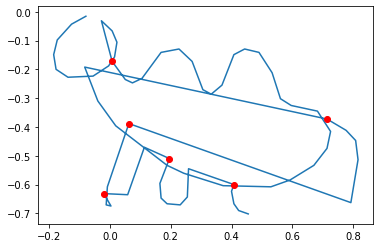

In [26]:
# Visualize and control output of `dict_to_stroke()`.

stroke = dict_to_stroke(sample[0])
# The first 2 dimensions are normalized dx/dy coordinates, and
# the third dimension indicates a new stroke.
xy = stroke[:2, :].cumsum(axis=1)
plt.plot(xy[0,:], -xy[1,:])
pxy = xy[:, stroke[2] != 0]
# Indicate the new stroke with a red circle.
plt.plot(pxy[0], -pxy[1], 'ro');

In [0]:
# Uses `dict_to_stroke()` from previous cell to create raster image.

def make_example_stroke(label, drawing):
  """Converts QuickDraw dictionary to example with stroke data.

  Args:
    label: Numerical representation of the label (e.g. '0' for labels[0]).
    drawing: Dictionary with QuickDraw data.

  Returns:
    A tf.train.Example protocol buffer (with 'label', 'stroke_x', 'stroke_y',
    'stroke_z', and additional metadata features).
  """
  example = tf.train.Example()
  example.features.feature['label'].int64_list.value.append(label)
  stroke = dict_to_stroke(drawing)
  example.features.feature['stroke_x'].float_list.value.extend(stroke[0, :])
  example.features.feature['stroke_y'].float_list.value.extend(stroke[1, :])
  example.features.feature['stroke_z'].float_list.value.extend(stroke[2, :])
  example.features.feature['stroke_len'].int64_list.value.append(
      stroke.shape[1])
  example.features.feature['countrycode'].bytes_list.value.append(
      drawing['countrycode'].encode())
  example.features.feature['recognized'].int64_list.value.append(
      drawing['recognized'])
  example.features.feature['word'].bytes_list.value.append(
      drawing['word'].encode())
  ts = drawing['timestamp']
  ts = time.mktime(time.strptime(ts[:ts.index('.')], '%Y-%m-%d %H:%M:%S'))
  example.features.feature['timestamp'].int64_list.value.append(int(ts))
  example.features.feature['key_id'].int64_list.value.append(
      int(drawing['key_id']))
  return example

In [28]:
path = '%s/%s_stroke' % (data_path, dataset_name)
t0 = time.time()
examples_per_split = make_sharded_files(
    make_example=make_example_stroke,
    path=path,
    labels=labels,
    iters=[loaditer(name) for name in labels],
    # Creating 50k train, 20k eval, 10k test examples. Takes ~2min
    counts=make_counts(labels, 80000),
    splits=dict(train=5, eval=2, test=1),
    overwrite=True,
    # Note: Set this to False when generating large datasets...
    make_df=True,
)

print('stored data to "%s"' % path)
print('generated %s examples in %d seconds' % (examples_per_split, time.time() - t0))

processed 14388/80000 (17.98%)
processed 28575/80000 (35.72%)
processed 43824/80000 (54.78%)
processed 62504/80000 (78.13%)
Writing /content/gdrive/My Drive/amld_data/zoo_stroke/dataframe.pkl...
stored data to "/content/gdrive/My Drive/amld_data/zoo_stroke"
generated {'eval': 20000, 'test': 10000, 'train': 50000} examples in 68 seconds


# ----- Optional part -----

## Inspect data

In [29]:
# YOUR ACTION REQUIRED:
# Check out the files generated in $data_path

# Note that you can also inspect the files in http://drive.google.com if you
# used Drive as the destination.
#--snip
!ls -lh "$data_path"/"$dataset_name"*

'/content/gdrive/My Drive/amld_data/zoo_img':
total 2.9G
-rw------- 1 root root   46 Feb 26 22:54 counts.json
-rw------- 1 root root 2.5G Feb 26 22:55 dataframe.pkl
-rw------- 1 root root  11M Feb 26 22:54 eval-00000-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00001-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00002-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00003-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00004-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00005-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00006-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00007-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00008-of-00010
-rw------- 1 root root  11M Feb 26 22:54 eval-00009-of-00010
-rw------- 1 root root   89 Feb 26 22:54 labels.txt
-rw------- 1 root root 5.1M Feb 26 22:54 test-00000-of-00010
-rw------- 1 root root 5.1M Feb 26 22:54 test-00001-of-00010
-rw------- 1 root root 5.1M Feb 26 22:54 test-00002

In [30]:
# Let's look at a single file of the sharded dataset.
tf_record_path = '{}/{}_img/eval-00000-of-00010'.format(data_path, dataset_name)
# YOUR ACTION REQUIRED:
# Use `tf.data.TFRecordDataset()` to read a single record from the file and 
# assign it to the variable `record`. What data type has this record?
# Hint: dataset is a Python "iterable".
#dataset = ...
#record
#--snip
for record in tf.data.TFRecordDataset(tf_record_path):
  break
# The record is a string Tensor that encodes the serialized protocol buffer.
record

<tf.Tensor: shape=(), dtype=string, numpy=b"\n\xfe'\n\x0e\n\x05label\x12\x05\x1a\x03\n\x01\t\n\x13\n\x04word\x12\x0b\n\t\n\x07penguin\n\x16\n\ttimestamp\x12\t\x1a\x07\n\x05\xcb\x96\xf4\xc6\x05\n\x16\n\x06key_id\x12\x0c\x1a\n\n\x08\x80\x80\x80\x87\xea\x8c\xbc\t\n\x13\n\nrecognized\x12\x05\x1a\x03\n\x01\x01\n\xfa&\n\x06img_64\x12\xef&\x1a\xec&\n\xe9&\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\xff\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x

In [31]:
# Check out the features. They should correspond to what we generated in
# `make_example_img()` above.
example = tf.train.Example()
# Note: `.numpy()` returns the underlying string from the Tensor.
example.ParseFromString(record.numpy())
print(list(example.features.feature.keys()))

['timestamp', 'key_id', 'recognized', 'img_64', 'countrycode', 'label', 'word']


In [0]:
# YOUR ACTION REQUIRED:
# Extract the label and the image data from the example protobuf.
# Use above section "tf.train.Example" for reference.
label_int = example.features.feature['label'].int64_list.value[0]  #label_int =
img_64 = example.features.feature['img_64'].int64_list.value  #img_64 = 

penguin


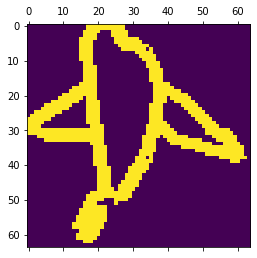

In [33]:
# Visualize the image:
print(labels[label_int])
plt.matshow(np.array(img_64).reshape((64, 64)))

(array([179., 184., 169., 184., 178., 175., 192., 184., 191., 188., 176.]),
 array([ 0.        ,  0.90909091,  1.81818182,  2.72727273,  3.63636364,
         4.54545455,  5.45454545,  6.36363636,  7.27272727,  8.18181818,
         9.09090909, 10.        ]),
 <a list of 11 Patch objects>)

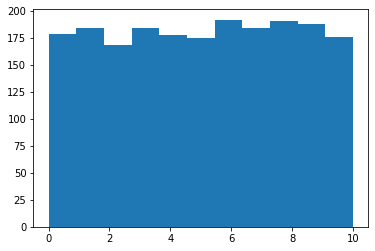

In [34]:
# YOUR ACTION REQUIRED:
# Check that we have an equal distribution of labels in the training files.
#--snip
sample = []
ds = tf.data.TFRecordDataset(tf_record_path)
for i, record in enumerate(itertools.islice(ds, 10000)):
  example = tf.train.Example()
  example.ParseFromString(record.numpy())
  sample.append(example.features.feature['label'].int64_list.value[0])
  if i == 10000: break
plt.hist(sample, bins=len(labels))

## More on protobufs

In [35]:
# If we want to create our own protocol buffers, we first need to install
# some programs.
!apt-get -y install protobuf-compiler python-pil python-lxml

Reading package lists... Done
Building dependency tree       
Reading state information... Done
protobuf-compiler is already the newest version (3.0.0-9.1ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  python-bs4 python-chardet python-html5lib python-olefile
  python-pkg-resources python-six python-webencodings
Suggested packages:
  python-genshi python-lxml-dbg python-lxml-doc python-pil-doc python-pil-dbg
  python-setuptools
The following NEW packages will be installed:
  python-bs4 python-chardet python-html5lib python-lxml python-olefile
  python-pil python-pkg-resources python-six python-webencodings
0 upgraded, 9 newly installed, 0 to remove and 25 not upgraded.
Need to get 1,818 kB of archives.
After this operation, 7,688 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 python-bs4

In [0]:
# Step 1: Write a proto file that describes our data format.
# YOUR ACTION REQUIRED: Complete the definition of the "Person" message (you
# can use the slide for inspiration).
with open('person.proto', 'w') as f:
  f.write('''syntax = "proto3";''')
#--snip
  f.write('''
message Person {
    string name = 1;
    string email = 2;
    repeated int32 lucky_numbers = 3;
}''')

In [37]:
# Step 2: Compile proto definition to a Python file.
!protoc --python_out=. person.proto
!ls -lh

total 16K
drwx------ 5 root root 4.0K Feb 26 22:48 gdrive
-rw-r--r-- 1 root root 2.5K Feb 26 22:57 person_pb2.py
-rw-r--r-- 1 root root  118 Feb 26 22:57 person.proto
drwxr-xr-x 1 root root 4.0K Feb  5 18:37 sample_data


In [0]:
# Step 3: Import code from generated Python file.
from person_pb2 import Person
# Note: If you change the person_pb2 module, you'll need to restart the kernel
# to see the changes because Python will still remember the previous import.

In [39]:
person = Person()
person.name = 'John Doe'
person.email = 'john.doe@gmail.com'
person.lucky_numbers.extend([13, 99])
person.SerializeToString()

b'\n\x08John Doe\x12\x12john.doe@gmail.com\x1a\x02\rc'

In [40]:
# YOUR ACTION REQUIRED:
# Compare the size of the serialized person structure in proto format
# vs. JSON encoded (you can use Python's json.dumps() and list members
# manually, or import google.protobuf.json_format).

# Which format is more efficient? Why?
# Which format is easier to use?
# Which format is more versatile?
#--snip
import json
print(len(person.SerializeToString()))
from google.protobuf.json_format import MessageToJson
len(MessageToJson(person))

34


97